In [1]:
import xarray as xr
import numpy as np
import os

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set_context('notebook')
sns.set_style('whitegrid')

## Runtime

[17.11.22] On a single node, single process:

### CFFI
---------

* total runtime: 488 s
* max runtime for warmrain: 390 seconds
* avg                     : 0.00048 seconds

### Fortran
------

* total runtime: 159 s
* max runtime for warmrain: 0.861 seconds
* avg                     : 0.00003 seconds

## Setup

In [3]:
def get_value(bridge='fortran', file='atm_2d', value='qrvi', cold=False):
    
    ds = get_ds(bridge=bridge, file=file, cold=cold)
    
    return ds[value]

In [4]:
def get_ds(bridge='fortran', file='atm_2d', cold=False):
    if cold:
        c = '_cold_'
    else:
        c = '_'
        
    expdir = f'/work/ka1176/caroline/gitlab/icon-aes/experiments/bubble_nproma_880{c}{bridge}/'    
        
    ds = xr.open_dataset(os.path.join(expdir, f'bubble_nproma_880{c}{bridge}_{file}_ml_20080801T000000Z.nc'))
    ds.close()
    
    time_mins = (ds.time - ds.time[0])*24*60 # min
    ds['time'] = time_mins
    
    return ds

In [5]:
def comparison_plot_2D(file='atm_2d', value='qrvi', cold=False, bridge='cffi'):
    c = get_value(bridge=bridge, value=value, cold=cold)
    f = get_value(bridge='fortran', value=value, cold=cold)    
    
    long_name = c.attrs['long_name']
    units = c.attrs['units']
    
    lbl = f'{long_name} ({units})'
    
    vmin = min(c.min(), f.min())
    vmax = max(c.max(), f.max())
    
    # left right bottom top
    extent = [c.time.min(), c.time.max(), c.ncells.min(), c.ncells.max()]
    
    sns.set_style('white')
    
    fig, ax = plt.subplots(1, 4, sharex=True, figsize=(18, 4))
    
    # Fortran    
    img=ax[0].imshow(f.T, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=extent)
    plt.colorbar(img, ax=ax[0], label=lbl)
    ax[0].set_title('Bubble (Fortran)')
    ax[0].set_ylabel('Grid cells')
    
    # CFFI
    img=ax[1].imshow(c.T, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=extent)
    plt.colorbar(img, ax=ax[1], label=lbl)
    ax[1].set_title(f'Bubble (ML via {bridge})')
    ax[1].set_ylabel('Grid cells')
    
    # Difference
    cf = c - f
    mav = np.max(np.abs(cf))
    img=ax[2].imshow(cf.T, aspect='auto', cmap='RdBu', vmin=-mav, vmax=+mav, extent=extent)
    plt.colorbar(img, ax=ax[2], label=lbl)
    ax[2].set_title('Difference (ML - Fortran)')
    ax[2].set_ylabel('Grid cells')
    
    # 1D Time evolution
    sf = f.mean(axis=1)
    sc = c.mean(axis=1)
        
    ax[3].plot(f.time, sf, label='Fortran', color='C0', lw=2)
    ax[3].plot(c.time, sc, label=f'ML via {bridge}', color='C3', lw=2)
    
    ax[3].legend()
    ax[3].set_ylabel(lbl)
    ax[3].set_title('Grid cell average')
    
    print(f'Value: {value}')
    print(f'Long name: {long_name}')
    print(f'Units: {units}')
    print()
    
    [axx.set_xlabel('Time (mins)') for axx in ax]
    
    fig.tight_layout()
    plt.savefig(f'/home/k/k202141/figures/iconml-bubble-{bridge}.png', bbox_inches='tight')

In [50]:
def paper_plot_rain(file='atm_2d', bridge='cffi'):
    value = 'qrvi'
    c = get_value(bridge=bridge, value=value)
    f = get_value(bridge='fortran', value=value)    
    
    long_name = c.attrs['long_name']
    units = c.attrs['units']
    
    lbl = f'{long_name} ({units})'
    
    vmin = min(c.min(), f.min())
    vmax = max(c.max(), f.max())
    
    # left right bottom top
    extent = [c.time.min(), c.time.max(), c.ncells.min(), c.ncells.max()]
    
    sns.set_context('paper')
    sns.set_style('ticks')
    
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(4, 4/1.6 * 1.0))
    
    # 1D Time evolution
    sf = f.sum(axis=1) * 10825317.547305
    sc = c.sum(axis=1) * 10825317.547305
        
    ax.plot(f.time, sf, label='Bulk-moment', color='C0', lw=2)
    ax.plot(c.time, sc, label=f'SuperDropNet', color='C3', lw=2)
    
    ax.legend()
    ax.set_ylabel('Grid-integrated rain (kg)')
    
    ax.set_xlabel('Time (mins)')
    
    #fig.text(0.5, 1, lbl, ha='center', va='top', fontsize='large')
    
    
    
    fig.tight_layout()
    plt.savefig(f'/home/k/k202141/figures/iconml-bubble-paper-{bridge}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'/home/k/k202141/figures/iconml-bubble-paper-{bridge}.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f'/home/k/k202141/figures/iconml-bubble-paper-{bridge}.eps', dpi=300, bbox_inches='tight')    

In [126]:
def plot_temporal_profile_paper(value, clbl=None, scale=1, cold=False, fill_rain=False, integrate=True):
    
    fds = get_ds(bridge='fortran', file='atm_2d', cold=cold)
    cds = get_ds(bridge='cffi', file='atm_2d', cold=cold)
    
    # figure setup
    nrows = 1
    ncols = 1
    sns.set_style('ticks')
    fig, ax = plt.subplots(nrows, ncols, figsize=(4, 4/1.6))
    
    time = fds['time']
    
    # rain season in fortran
    # FWHM in the warm scenario: 29, 46
    frain = get_value().sum(axis=-1)
    frl = frain.time[frain>frain.max()/2][0].values
    frr = frain.time[frain>frain.max()/2][-1].values
    
    # values
    fv = fds[value]
    cv = cds[value]
    
    if integrate: # multiply sum by grid cell area
        fvvv = fv.sum(axis=-1) * 10825317.547305
        cvvv = cv.sum(axis=-1) * 10825317.547305
    else:
        fvvv = fv.mean(axis=-1)
        cvvv = cv.mean(axis=-1)
        
    if clbl is None:
        long_name = fv.attrs['long_name']
        units = fv.attrs['units']
        clbl = f'{long_name} ({units})'
        
        
    ax.plot(time, fvvv * scale, lw=2, color='C0', label='Bulk moment')
    ax.plot(time, cvvv * scale, lw=2, color='C3', label='SuperDropNet')
    ax.legend(loc=5)
    ax.set_ylabel(clbl)
        
    ylim = ax.get_ylim()
    
    ax.set_ylim(ylim)
 
    ax.set_xlabel('Time (mins)')
    ax.set_xticks([0, 20, 40, 60, 80, 100, 120])
    
    if fill_rain:
        #ax.fill_between(np.arange(frl, frr), ylim[0], ylim[1], color='C7', alpha=0.5)
        ax2 = plt.twinx(ax)
        ax2.fill_between(time, frain, color='C7', alpha=0.25, zorder=100)
        ax2.set_yticks([])

                        
    fig.tight_layout()
    plt.savefig(f'/home/k/k202141/figures/iconml-bubble-paper-{value}-cold-{cold}.png', dpi=300, bbox_inches='tight')

## Paper plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


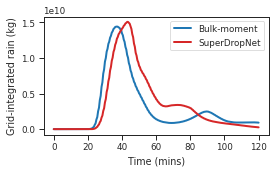

In [127]:
paper_plot_rain()

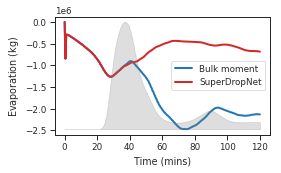

In [128]:
plot_temporal_profile_paper('evspsbl', clbl=r'Evaporation $(\mathrm{kg})$', scale=1, fill_rain=True)

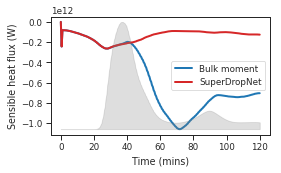

In [129]:
plot_temporal_profile_paper('hfss', clbl='Sensible heat flux (W)', fill_rain=True)

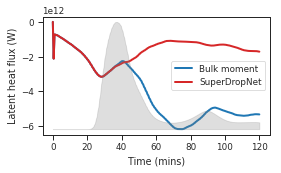

In [130]:
plot_temporal_profile_paper('hfls', clbl='Latent heat flux (W)', fill_rain=True)

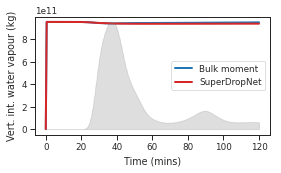

In [131]:
plot_temporal_profile_paper('prw', clbl='Vert. int. water vapour (kg)', fill_rain=True)

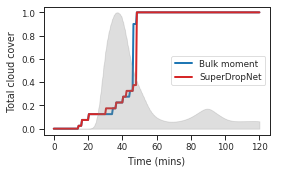

In [132]:
plot_temporal_profile_paper('clt', clbl='Total cloud cover', fill_rain=True, integrate=False)

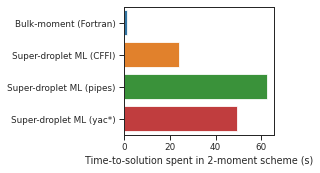

In [125]:
bridges = ['Bulk-moment (Fortran)', 'Super-droplet ML (CFFI)', 'Super-droplet ML (pipes)', 'Super-droplet ML (yac*)']
t2mom_max = [1.254, 24.128, 62.597, 49.492]
t2mom_880 = [23.84, 485, 52, 49.492]
df = pd.DataFrame(dict(bridge=bridges, t2mom_max=t2mom_max))

fig=plt.figure(figsize=(4, 4/1.6))
sns.barplot(data=df, y='bridge', x='t2mom_max', ax=plt.gca())
ax=plt.gca()
ax.set_ylabel('')
ax.set_xlabel('Time-to-solution spent in 2-moment scheme (s)')
fig.tight_layout()
plt.savefig(f'/home/k/k202141/figures/iconml-paper-bubble-bench.png', bbox_inches='tight')

## Atmosphere 2D variables

In [7]:
grid = xr.open_dataset('/home/k/k202141/rootgit/icon-aes/experiments/bubble_nproma_32_fortran/Torus_Triangles_20x22_5000m.nc')
grid['cell_area']

<xarray.DataArray 'cell_area' (cell: 880)>
array([10825317.547305, 10825317.547305, 10825317.547305, ..., 10825317.547305,
       10825317.547305, 10825317.547305])
Coordinates:
    clon     (cell) float64 ...
    clat     (cell) float64 ...
Dimensions without coordinates: cell
Attributes:
    long_name:                    area of grid cell
    units:                        m2
    standard_name:                area
    grid_type:                    unstructured
    number_of_grid_in_reference:  1

Value: qrvi
Long name: vertically integrated rain
Units: kg m-2

Value: clivi
Long name: vertically integrated cloud ice
Units: kg m-2

Value: qsvi
Long name: vertically integrated snow
Units: kg m-2



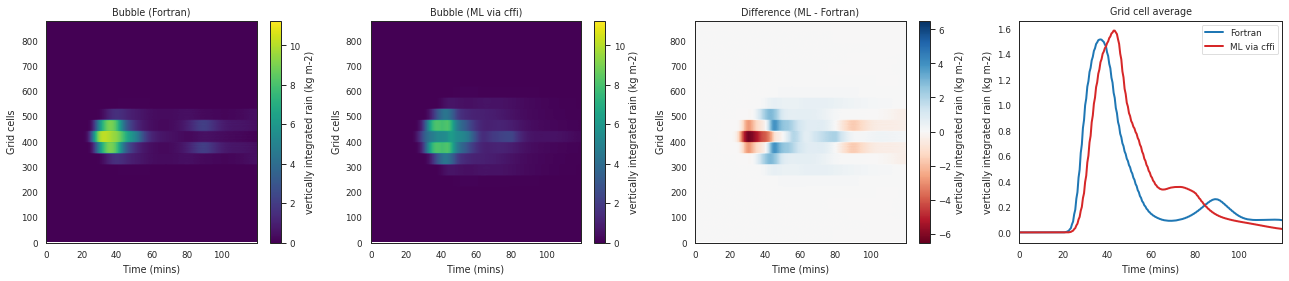

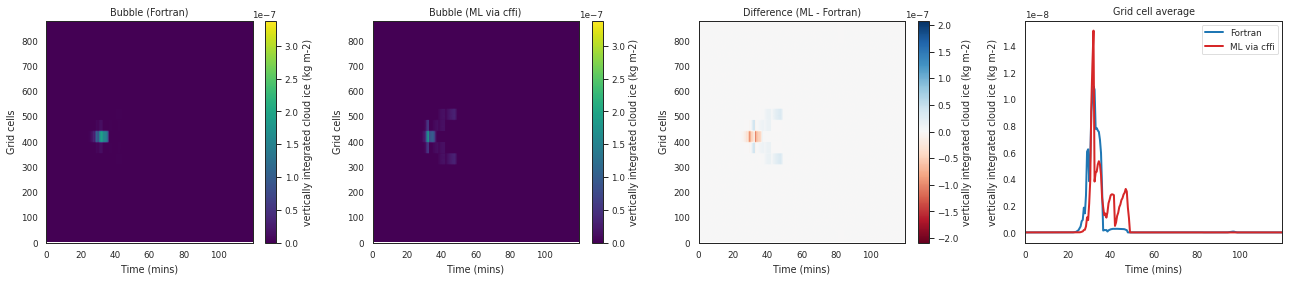

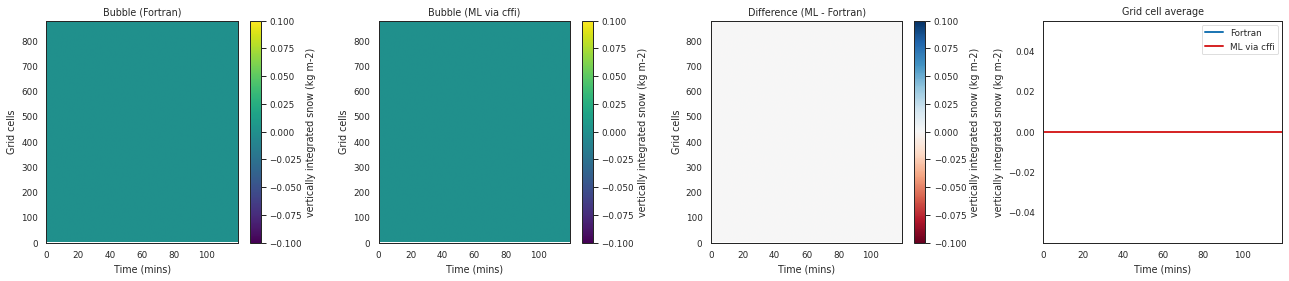

In [10]:
atm_2d_vi = ['qrvi', 'clivi', 'qsvi']

for value in atm_2d_vi:

    comparison_plot_2D(value=value, cold=False, bridge='cffi')

Value: qrvi
Long name: vertically integrated rain
Units: kg m-2

Value: clivi
Long name: vertically integrated cloud ice
Units: kg m-2

Value: qsvi
Long name: vertically integrated snow
Units: kg m-2



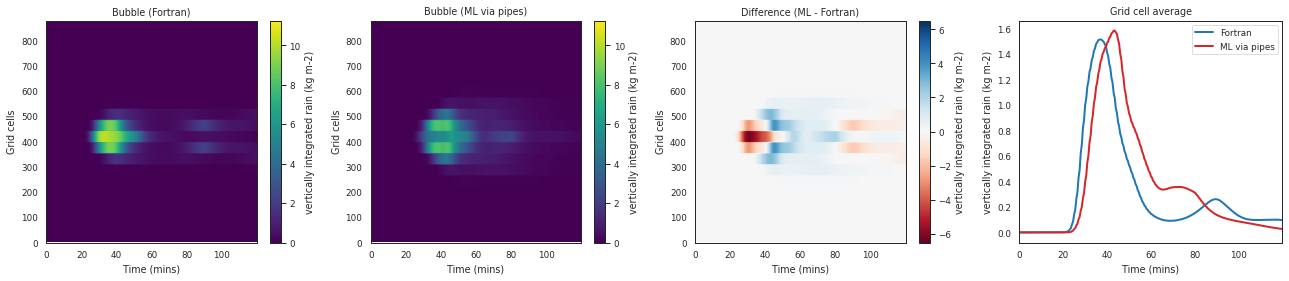

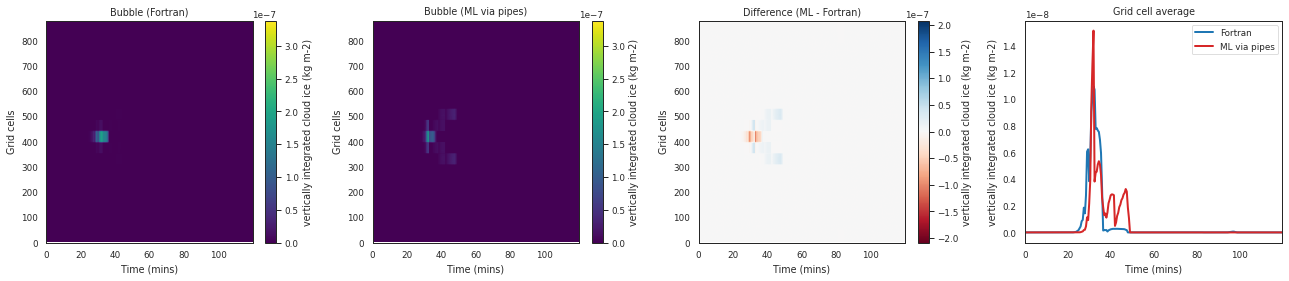

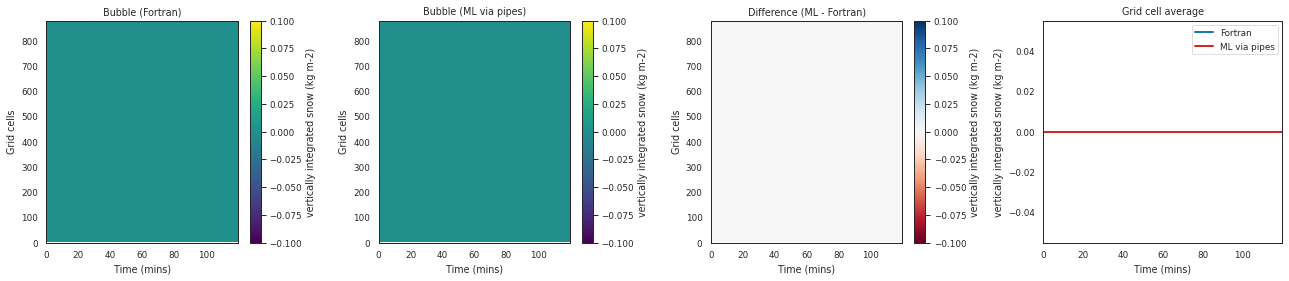

In [11]:
atm_2d_vi = ['qrvi', 'clivi', 'qsvi']

for value in atm_2d_vi:

    comparison_plot_2D(value=value, cold=False, bridge='pipes')

Value: qrvi
Long name: vertically integrated rain
Units: kg m-2

Value: clivi
Long name: vertically integrated cloud ice
Units: kg m-2

Value: qsvi
Long name: vertically integrated snow
Units: kg m-2



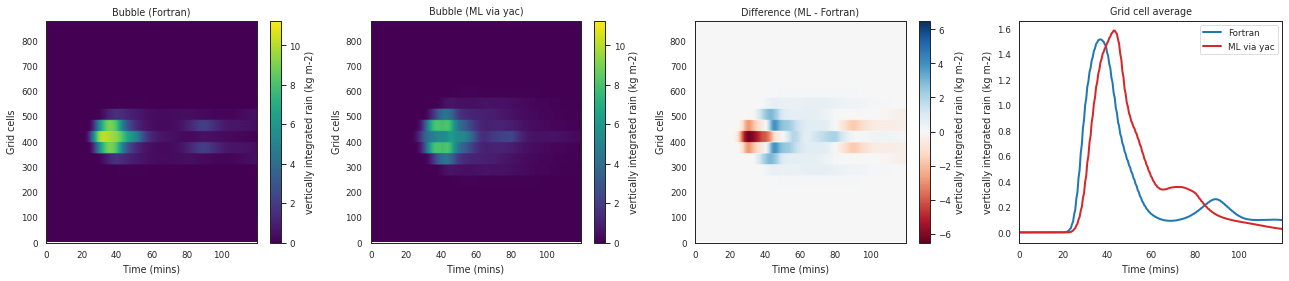

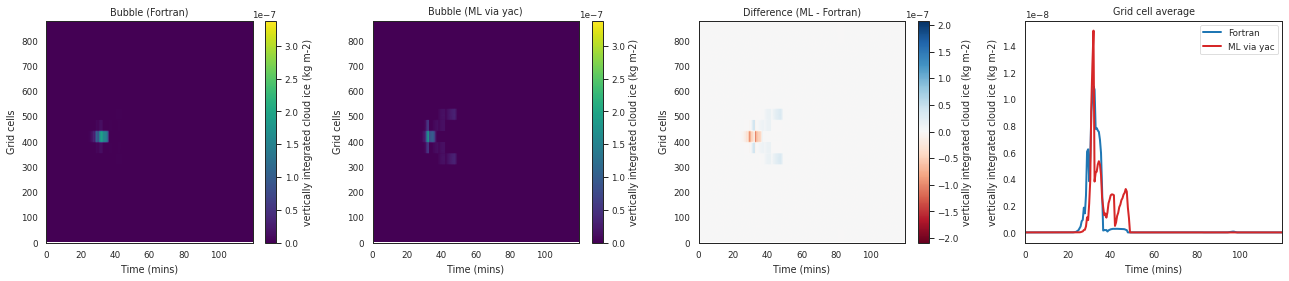

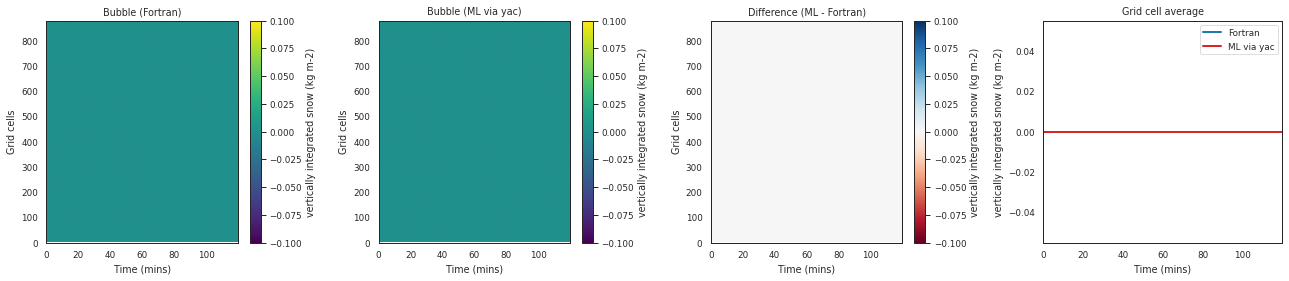

In [12]:
atm_2d_vi = ['qrvi', 'clivi', 'qsvi']

for value in atm_2d_vi:

    comparison_plot_2D(value=value, cold=False, bridge='yac')

Value: pr_rain
Long name: stratiform rainfall flux (cloud_two output)
Units: kg/m2/s

Value: pr_snow
Long name: stratiform snowfall flux (cloud_two output)
Units: kg/m2/s

Value: pr_grpl
Long name: stratiform graupel flux (cloud_two output)
Units: kg/m2/s

Value: pr_ice
Long name: stratiform icefall flux (cloud_two output)
Units: kg/m2/s



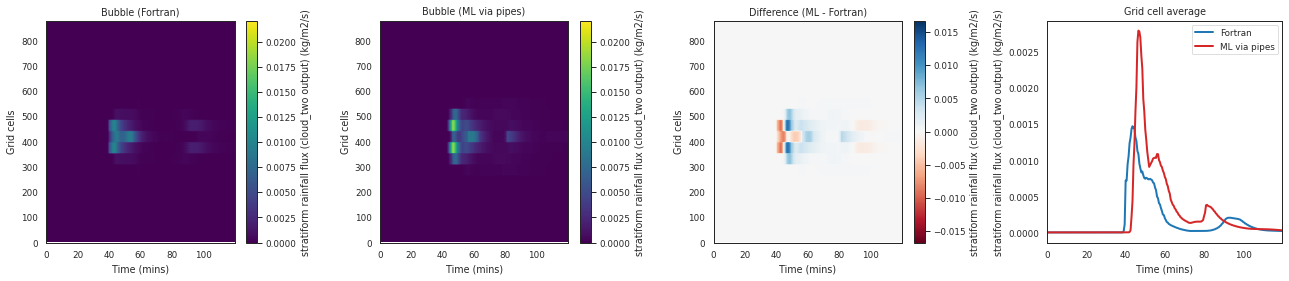

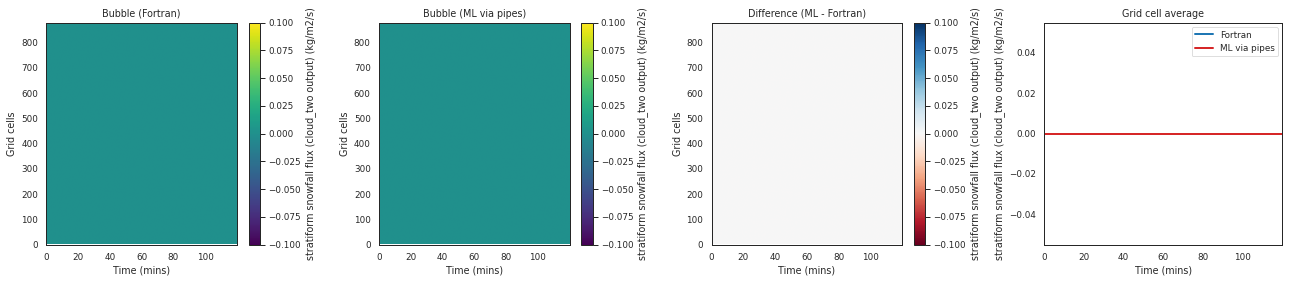

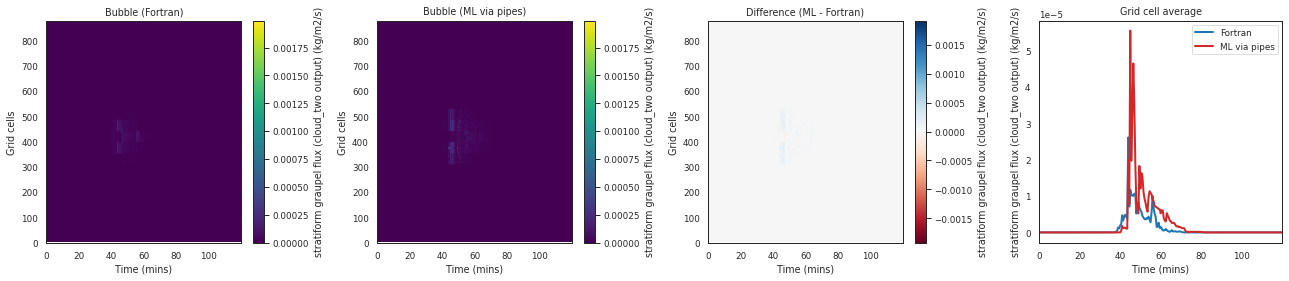

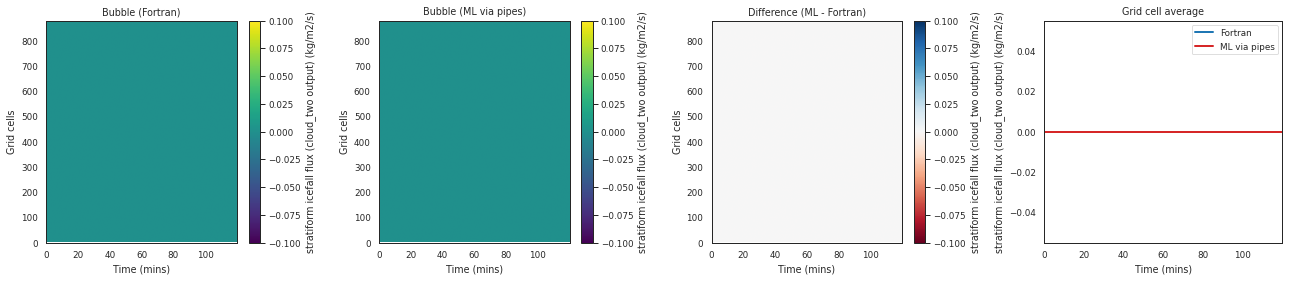

In [13]:
atm_2d_flux = ['pr_rain', 'pr_snow', 'pr_grpl', 'pr_ice']

for value in atm_2d_flux:

    comparison_plot_2D(value=value, cold=False, bridge='pipes')

Value: pr_rain
Long name: stratiform rainfall flux (cloud_two output)
Units: kg/m2/s

Value: pr_snow
Long name: stratiform snowfall flux (cloud_two output)
Units: kg/m2/s

Value: pr_grpl
Long name: stratiform graupel flux (cloud_two output)
Units: kg/m2/s

Value: pr_ice
Long name: stratiform icefall flux (cloud_two output)
Units: kg/m2/s



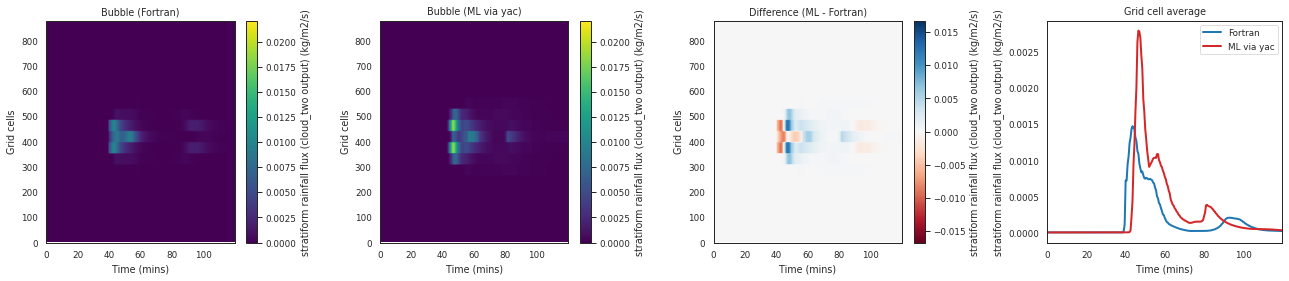

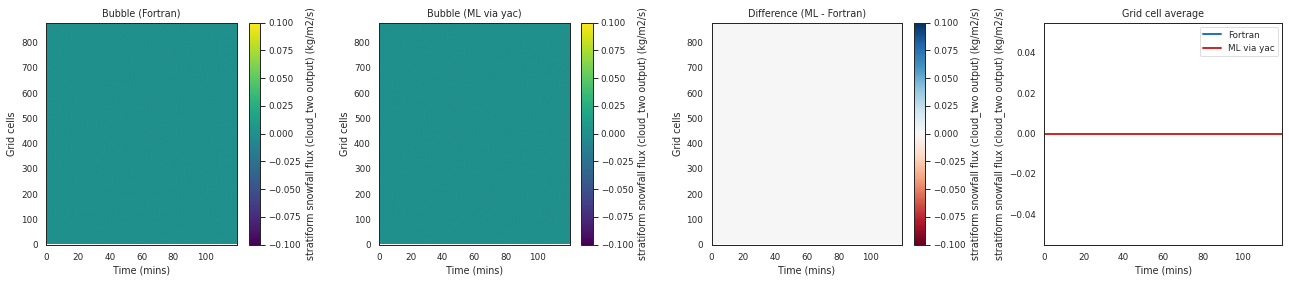

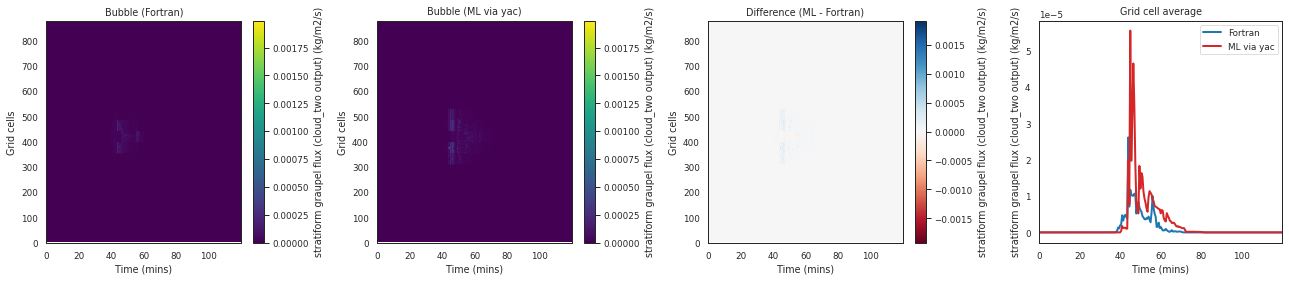

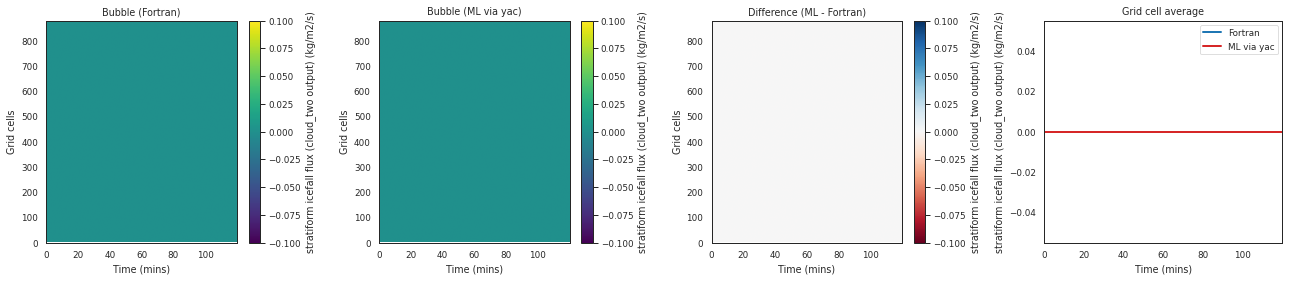

In [14]:
atm_2d_flux = ['pr_rain', 'pr_snow', 'pr_grpl', 'pr_ice']

for value in atm_2d_flux:

    comparison_plot_2D(value=value, cold=False, bridge='yac')

In [15]:
ds = get_ds(file='atm_2d')
ds

<xarray.Dataset>
Dimensions:    (time: 241, ncells: 880, vertices: 3)
Coordinates:
  * time       (time) float64 0.0 0.5 1.0 1.5 2.0 ... 118.5 119.0 119.5 120.0
    clon       (ncells) float32 ...
    clat       (ncells) float32 ...
Dimensions without coordinates: ncells, vertices
Data variables: (12/22)
    clon_bnds  (ncells, vertices) float32 ...
    clat_bnds  (ncells, vertices) float32 ...
    ps         (time, ncells) float64 ...
    psl        (time, ncells) float64 ...
    ts         (time, ncells) float64 ...
    clt        (time, ncells) float64 ...
    ...         ...
    prls       (time, ncells) float64 ...
    cptgzvi    (time, ncells) float64 ...
    pr_rain    (time, ncells) float64 ...
    pr_snow    (time, ncells) float64 ...
    pr_grpl    (time, ncells) float64 ...
    pr_ice     (time, ncells) float64 ...
Attributes:
    CDI:                  Climate Data Interface version 1.8.4 (http://mpimet...
    Conventions:          CF-1.6
    number_of_grid_used:  42
    uuidOfHGrid:          f978b88c-3677-11e9-b648-1fcceafacc15
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:k202141/icon-aes.git@9073d06a212...
    history:              /home/k/k202141/rootgit/icon-aes/bin/icon at 202301...
    references:           see MPIM/DWD publications
    comment:              Caroline Arnold (k202141) on l30690 (Linux 4.18.0-3...

## Atmosphere 3D variables

In [16]:
ds = get_ds(bridge='cffi', file='atm_3d')
ds

<xarray.Dataset>
Dimensions:      (time: 241, ncells: 880, vertices: 3, height: 70, bnds: 2, height_2: 71)
Coordinates:
  * time         (time) float64 0.0 0.5 1.0 1.5 2.0 ... 118.5 119.0 119.5 120.0
    clon         (ncells) float32 ...
    clat         (ncells) float32 ...
  * height       (height) float64 1.0 2.0 3.0 4.0 5.0 ... 67.0 68.0 69.0 70.0
  * height_2     (height_2) float64 1.0 2.0 3.0 4.0 5.0 ... 68.0 69.0 70.0 71.0
Dimensions without coordinates: ncells, vertices, bnds
Data variables: (12/26)
    clon_bnds    (ncells, vertices) float32 ...
    clat_bnds    (ncells, vertices) float32 ...
    height_bnds  (height, bnds) float64 ...
    ps           (time, ncells) float64 ...
    pfull        (time, height, ncells) float64 ...
    zg           (height, ncells) float64 ...
    ...           ...
    qnr          (time, height, ncells) float64 ...
    qns          (time, height, ncells) float64 ...
    qng          (time, height, ncells) float64 ...
    qnh          (time, height, ncells) float64 ...
    qnc          (time, height, ncells) float64 ...
    ninact       (time, height, ncells) float64 ...
Attributes:
    CDI:                  Climate Data Interface version 1.8.4 (http://mpimet...
    Conventions:          CF-1.6
    number_of_grid_used:  42
    uuidOfHGrid:          f978b88c-3677-11e9-b648-1fcceafacc15
    uuidOfVGrid:          36987ca3-08bc-7f9a-a506-45859f4c1ca0
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:k202141/icon-aes.git@9073d06a212...
    history:              /home/k/k202141/rootgit/icon-aes/bin/icon at 202301...
    references:           see MPIM/DWD publications
    comment:              Caroline Arnold (k202141) on l30692 (Linux 4.18.0-3...

In [17]:
(ds['clw']>0).sum() / 70 / 240 / 880

<xarray.DataArray 'clw' ()>
array(0.04474134)

In [18]:
ua = ds['ua'].values
va = ds['va'].values
wa = ds['wa'].values
ua.shape, va.shape, wa.shape

((241, 70, 880), (241, 70, 880), (241, 71, 880))

In [19]:
y = np.sqrt(ua**2 + va**2 + wa[:,:-1,:]**2)[40] / 3.6 # m / s = 1/1000 km / 1/3600 h = 3600 / 1000 km / h = 3.6 km /h

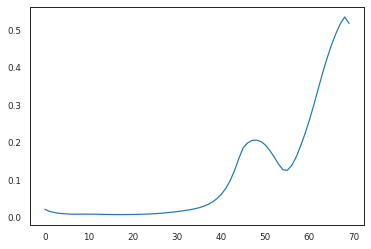

In [20]:
plt.plot(np.mean(y, axis=1))

In [21]:
import cffi
cffi.__version__

'1.14.6'

### Moments

In [22]:
def plot_height_profile(hydrometeors=['cloud', 'rain'], cold=False, moment='specific_content'):
    
    if moment == 'specific_content':
        mom = ['clw', 'qr', 'cli', 'qs', 'qg', 'qh']
        clbl = 'specific content (kg/kg)'
        cmap = 'Blues'
    elif moment == 'number_concentration':
        mom = ['qnc', 'qnr', 'qni', 'qns', 'qng', 'qnh']
        clbl = 'number concentration (1/kg)'
        cmap = 'Oranges'
    else:
        raise ValueError
    
    if isinstance(hydrometeors, str):
        hydrometeors = [hydrometeors]
    
    # global settings
    all_hydrometeors = ['cloud', 'rain', 'ice', 'snow', 'graupel', 'hail']
    
    fds = get_ds(bridge='fortran', file='atm_3d', cold=cold)
    cds = get_ds(bridge='cffi', file='atm_3d', cold=cold)
    
    # figure setup
    nrows = len(hydrometeors)
    sns.set_style('white')
    fig, ax = plt.subplots(nrows, 3, figsize=(18, nrows*4))
    ax = ax.reshape(nrows, -1)
    
    # left right bottom top
    zg = fds['zg']
    extent = [fds.time.min(), fds.time.max(), fds.zg.min(), fds.zg.max()]
    
    cmap2 = 'PRGn'
    
    for i, hmet in enumerate(hydrometeors):
        j = all_hydrometeors.index(hmet)
        
        # values
        fv = fds[mom[j]]
        fvv = fv.sum(axis=2)
        cv = cds[mom[j]]
        cvv = cv.sum(axis=2)
        
        vmin = min(fvv.min(), cvv.min())
        vmax = max(fvv.max(), cvv.max())
        
        # Fortran moment 1
        img=ax[i,0].imshow(fvv.T, aspect='auto', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
        plt.colorbar(img, label=clbl, ax=ax[i,0])
        ax[i,0].set_title(f'{hmet} (Fortran)')
        
        # CFFI moment 1
        img=ax[i,1].imshow(cvv.T, aspect='auto', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
        plt.colorbar(img, label=clbl, ax=ax[i,1])
        ax[i,1].set_title(f'{hmet} (ML via CFFI)')
        
        # Diff
        diff = (cv - fv).sum(axis=2)
        mav = np.max(np.abs(diff))
        img=ax[i,2].imshow(diff.T, aspect='auto', extent=extent, vmin=-mav, vmax=+mav, cmap=cmap2)
        plt.colorbar(img, label=clbl, ax=ax[i,2])
        ax[i,2].set_title(f'{hmet} difference (ML - Fortran)')
        
    
    [axx.set_xlabel('Time (mins)') for axx in ax.flatten()]
    [axx.set_ylabel('Geometric height (m)') for axx in ax.flatten()]
        
    fig.tight_layout()

In [23]:
def plot_vertical_profile(values, cold=False):
    
    fds = get_ds(bridge='fortran', file='atm_3d', cold=cold)
    cds = get_ds(bridge='cffi', file='atm_3d', cold=cold)
    
    # figure setup
    nrows = len(values)
    ncols = 4
    sns.set_style('white')
    fig, ax = plt.subplots(nrows, ncols, figsize=(18, nrows*4))
    ax = ax.reshape(nrows, -1)
    
    # left right bottom top
    zg = fds['zg']
    extent = [fds.time.min(), fds.time.max(), fds.zg.min(), fds.zg.max()]
    
    cmap = 'Blues'
    cmap2 = 'PRGn'
        
    for i, value in enumerate(values):        
        # values
        fv = fds[value]
        fvv = fv.mean(axis=2)
        cv = cds[value]
        cvv = cv.mean(axis=2)
        
        vmin = min(fvv.min(), cvv.min())
        vmax = max(fvv.max(), cvv.max())
        
        long_name = fv.attrs['long_name']
        units = fv.attrs['units']
    
        clbl = f'{long_name} ({units})'
        
        # Fortran
        img=ax[i,0].imshow(fvv.T, aspect='auto', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
        plt.colorbar(img, label=clbl, ax=ax[i,0])
        ax[i,0].set_title(f'{long_name} (Fortran)')
        
        # CFFI
        img=ax[i,1].imshow(cvv.T, aspect='auto', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
        plt.colorbar(img, label=clbl, ax=ax[i,1])
        ax[i,1].set_title(f'{long_name} (ML via CFFI)')
        
        # Diff
        diff = (cv - fv).mean(axis=2)
        mav = np.max(np.abs(diff))
        img=ax[i,2].imshow(diff.T, aspect='auto', extent=extent, vmin=-mav, vmax=+mav, cmap=cmap2)
        plt.colorbar(img, label=clbl, ax=ax[i,2])
        ax[i,2].set_title(f'{long_name} difference (ML - Fortran)')
        
                
        # Time step
        t_ix = 160
        
        ax[i,3].plot(fvv[t_ix].values, zg.mean(axis=-1), lw=2, color='C2', label=f'Fortran {fvv[t_ix].time.values:.0f} min')
        ax[i,3].plot(cvv[t_ix].values, zg.mean(axis=-1), lw=2, color='C3', label=f'ML {cvv[t_ix].time.values:.0f} min')
        ax[i,3].set_xlabel(clbl)        
        ax[i,3].legend()
        
    [axx.set_xlabel('Time (mins)') for axx in ax[:,:3].flatten()]
    [axx.set_ylabel('Geometric height (m)') for axx in ax.flatten()]
    [axx.set_ylim(0, 7000) for axx in ax.flatten()]
                        
    fig.tight_layout()

In [24]:
def plot_temporal_profile(values, cold=False):
    
    fds = get_ds(bridge='fortran', file='atm_2d', cold=cold)
    cds = get_ds(bridge='cffi', file='atm_2d', cold=cold)
    
    # figure setup
    nrows = 1
    ncols = len(values)
    sns.set_style('white')
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*5, 4.5))
    ax = ax.reshape(nrows, -1)
    
    time = fds['time']
    
    # rain season in fortran
    # FWHM in the warm scenario: 29, 46
    frain = get_value().sum(axis=-1)
    frl = frain.time[frain>frain.max()/2][0].values
    frr = frain.time[frain>frain.max()/2][-1].values
    print('Gray scale: rain FWHM')
    
    for i, value in enumerate(values):        
        # values
        fv = fds[value]
        fvvv = fv.mean(axis=-1)
        cv = cds[value]
        cvvv = cv.mean(axis=-1)
        
        long_name = fv.attrs['long_name']
        units = fv.attrs['units']
    
        clbl = f'{long_name} ({units})'
        
        
        ax[0,i].plot(time, fvvv, lw=2, color='C2', label='Fortran')
        ax[0,i].plot(time, cvvv, lw=2, color='C3', label='ML')
        ax[0,i].legend(loc=1)
        ax[0,i].set_ylabel(clbl)
        
        ylim = ax[0,i].get_ylim()
        
        ax[0,i].fill_between(np.arange(frl, frr), ylim[0], ylim[1], color='C7', alpha=0.5)
        ax[0,i].set_ylim(ylim)

        
    [axx.set_xlabel('Time (mins)') for axx in ax.flatten()]

                        
    fig.tight_layout()

Gray scale: rain FWHM


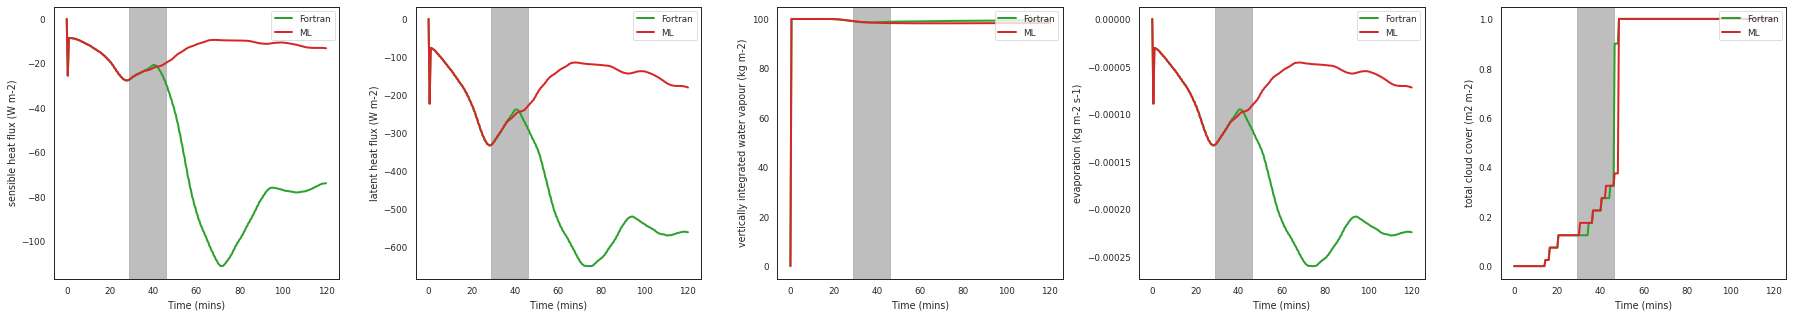

In [25]:
plot_temporal_profile(['hfss', 'hfls', 'prw', 'evspsbl', 'clt'])

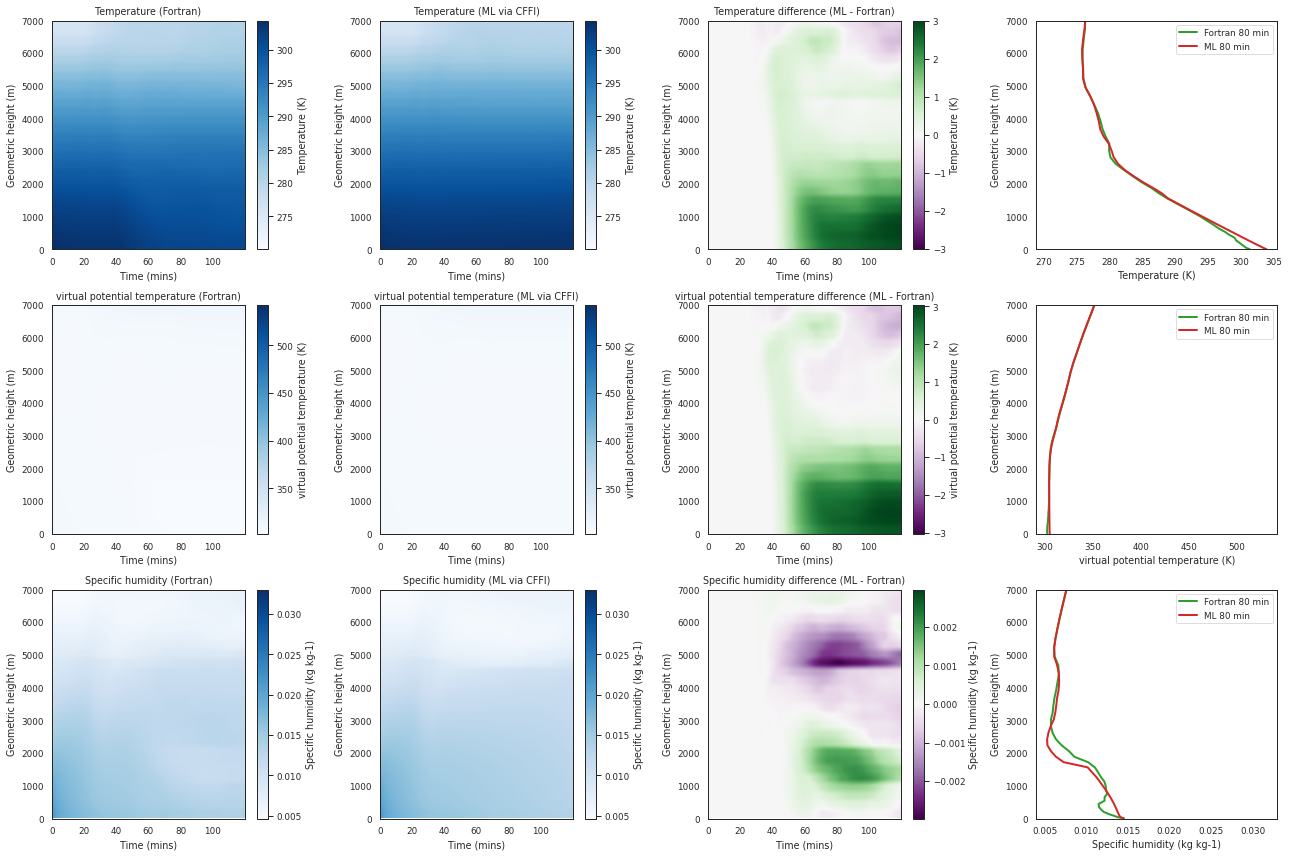

In [26]:
plot_vertical_profile(['ta', 'theta_v', 'hus'])

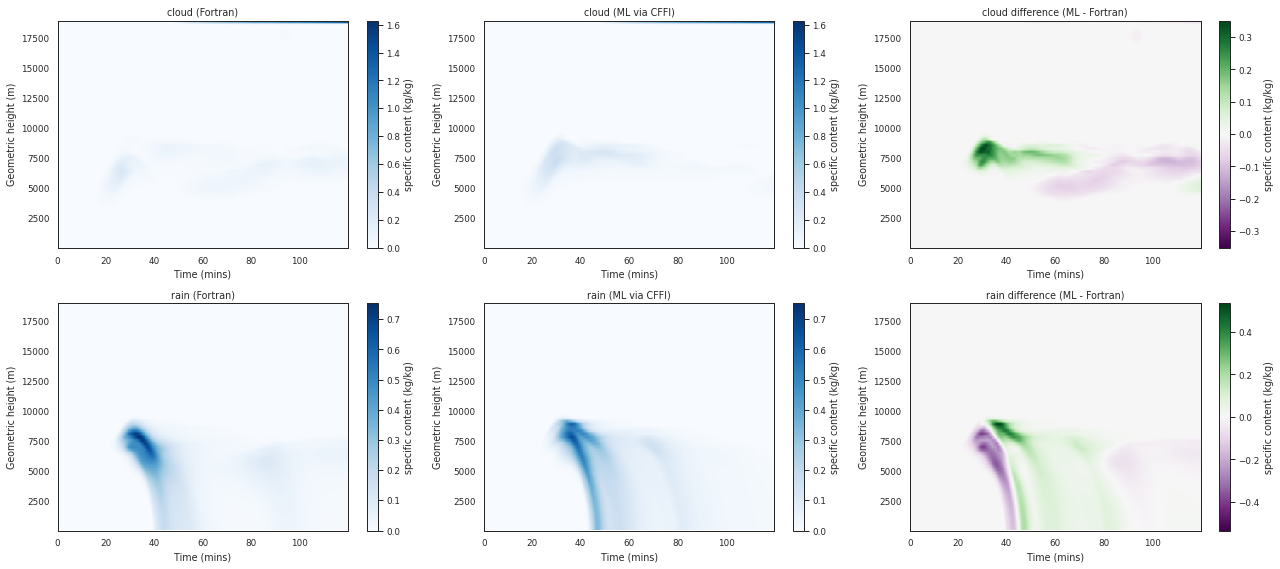

In [27]:
plot_height_profile(['cloud', 'rain'], cold=False, moment='specific_content')

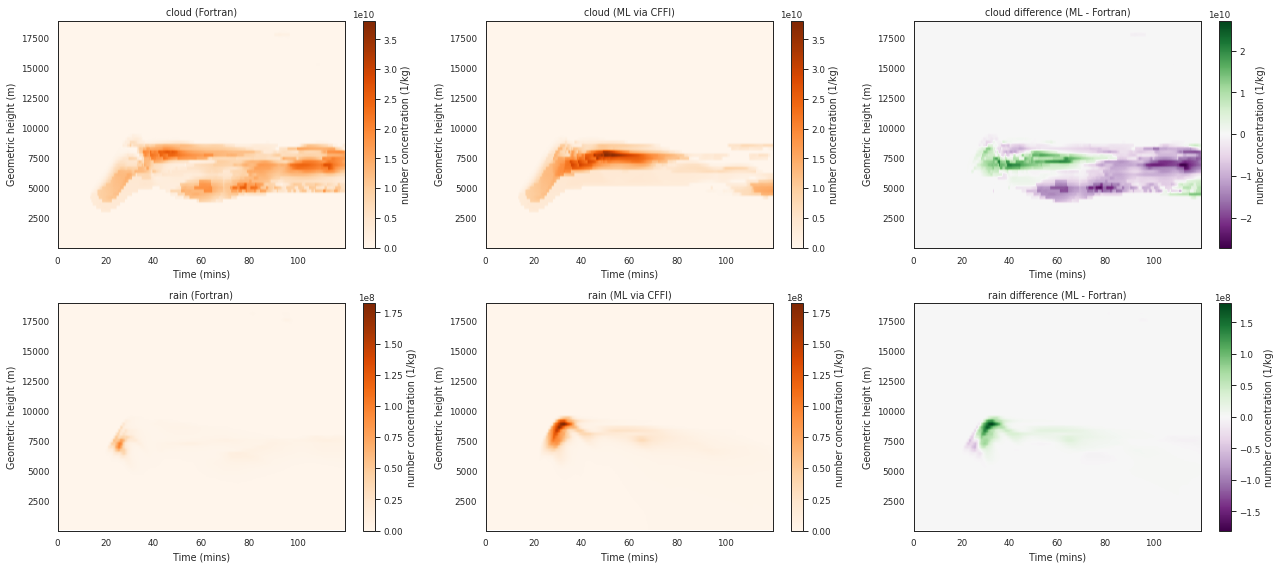

In [28]:
plot_height_profile(['cloud', 'rain'], cold=False, moment='number_concentration')

ValueError: x and y must have same first dimension, but have shapes (71,) and (70,)

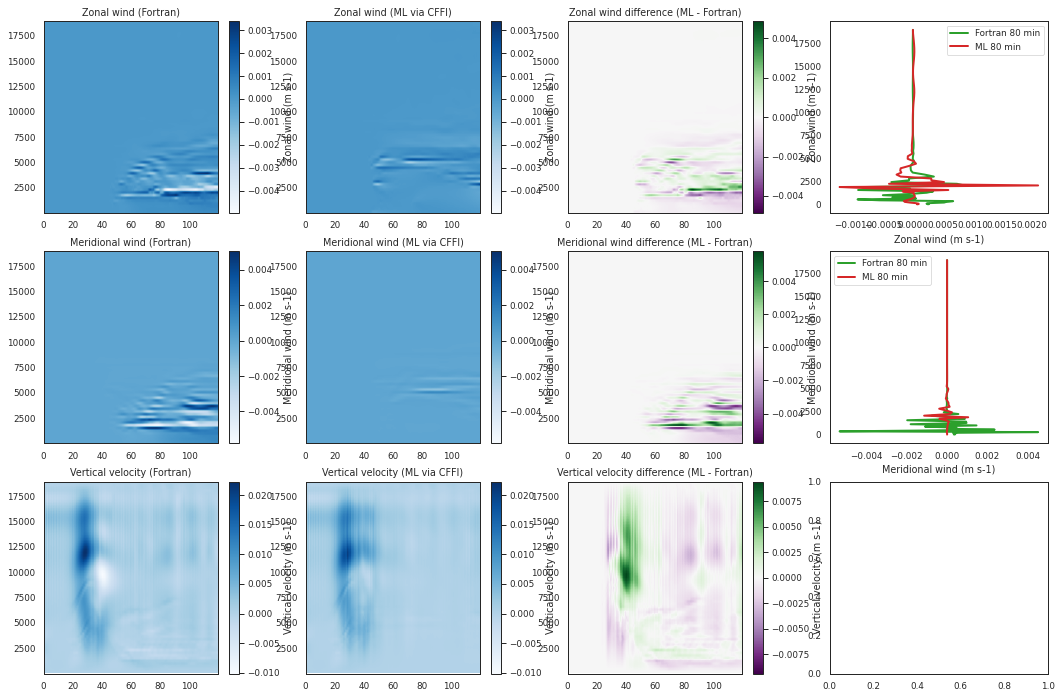

In [29]:
plot_vertical_profile(['ua', 'va', 'wa'])

# Below: debugging the solver

In [ ]:
bef = np.load('/work/ka1176/caroline/gitlab/icon-aes/experiments/bubble_nproma_880_yac/before_2008-01-01 00:13:00_53.npy')
aft = np.load('/work/ka1176/caroline/gitlab/icon-aes/experiments/bubble_nproma_880_yac/after_2008-01-01 00:13:00_53.npy')

In [ ]:
np.isnan(bef).sum(), np.isnan(aft).sum(), np.sum(aft>1e20)

In [ ]:
bef[:,2], aft[:,2]

In [ ]:
(np.sum(np.abs(bef.T), axis=1) < 1e-9)

In [ ]:
zero_ix = np.where( np.allclose(np.sum( np.abs( bef.T ), axis=1), 0))[0]
zero_ix

In [ ]:
import sys
sys.path.append('/work/ka1176/caroline/gitlab/icon-aes/externals/mlbridges/cffi_interface/')
sys.path.append('/work/ka1176/caroline/gitlab/icon-aes/externals/mlbridges/lib/')

In [ ]:
import libcffi
from libcffi import ffi
import numpy as np
import os
import transfer_arrays
import torch

import sys
from solvers.moment_solver import simulation_forecast

import models.plModel as plm

#new = np.empty(bef.shape)

In [ ]:
# initialization code
# TODO execute this in the load_pretrained_model function
inputs_mean = np.asarray([[0.0002621447787797809, 51128093.51524663,
                0.0003302890736022656, 5194.251154308974,
                0.5566250557023539, 4.8690682855354596e-12,
                0.0005924338523807814, 1.0848856769219835e-05,
                2.0193905073168525]])

inputs_std = np.asarray([[0.0003865559774857862, 86503916.13808665,
                0.00041369562655559327, 19127.947970150628,
                0.46107363560819126, 3.873092422358367e-12,
                0.00042887039563850967, 1.920461805101116e-06,
                1.3098055608321857]])

updates_mean = np.asarray([[-8.527820407019667e-08, -13961.459867976775,
                8.527678028525988e-08, 0.010221931180955181]])

updates_std = np.asarray([[3.600841676033818e-07, 55095.904252313965,
                3.6008419243808887e-07, 68.6678997504877]])

pl_model = plm.LightningModel(inputs_mean=inputs_mean, inputs_std=inputs_std,
                            updates_mean=updates_mean, updates_std=updates_std) 

model_path = '/work/ka1176/caroline/gitlab/icon-aes/externals/mlbridges/cffi_interface/trained_models/best_model.ckpt'
trained_model = pl_model.load_from_checkpoint(model_path)


In [ ]:
if torch.cuda.is_available():
    trained_model = trained_model.to('cuda')

In [ ]:
%%timeit
bef = np.zeros([880, 4])

In [ ]:
%%timeit
swapped_moments = np.swapaxes(bef, 0, 1)
#if torch.cuda.is_available():
#    swapped_moments = torch.from_numpy(swapped_moments).to('cuda')
   

In [ ]:
swapped_moments = np.swapaxes(bef, 0, 1)

In [ ]:
%%timeit
new_forecast = simulation_forecast(swapped_moments, trained_model,
                                           inputs_mean, inputs_std,
                                           updates_mean, updates_std)

In [ ]:
new_forecast = simulation_forecast(swapped_moments, trained_model,
                                           inputs_mean, inputs_std,
                                           updates_mean, updates_std)

In [ ]:
%%timeit
new_forecast.test()

In [ ]:
# average times
dt_put = 0.00002
dt_pym = 0.00151
dt_wrm = 0.00119
dt_wrm_cffi = 

dt_wrm - (dt_put + dt_pym)

In [ ]:
((ds['clw'].sum(axis=-1) + ds['qr'].sum(axis=-1) + ds['qnc'].sum(axis=-1) + ds['qnr'].sum(axis=-1))>0).sum()

In [ ]:
10261 * dt_pym 

In [ ]:
8.561/0.00034 

In [ ]:
dt_put / dt_wrm, dt_pym / dt_wrm

In [ ]:
a = np.zeros(24).reshape(6, 4)
a[0,0] = 1e-10
fc3 = simulation_forecast(a, trained_model, inputs_mean, inputs_std, updates_mean, updates_std)
fc3.test()
print(fc3.moments_out)
print(fc3.moments_out.shape)
del fc3

In [ ]:
man2 = []
for i in range(880):
    if np.allclose(swapped_moments[i], 0):
        continue
    nfc2 = simulation_forecast(swapped_moments[i], trained_model, 
                              inputs_mean, inputs_std, updates_mean, updates_std)
    nfc2.test()
    man2.append(nfc2.moments_out)
    
man2 = np.asarray(man2).squeeze()
print(man2.shape)

In [ ]:
man = new_forecast.moments_out
np.any(man>1e20)

In [ ]:
np.allclose(man, man2)

In [ ]:
zero_ix = np.where(np.sum(swapped_moments, axis=1) == 0)
man2 = np.copy(man)
man2[zero_ix] = 0
np.any(man2>1e20)

In [ ]:
np.isnan(man).sum(), np.isnan(aft).sum(), man.shape

In [ ]:
new[:, :] = np.swapaxes(man, 0, 1)

In [ ]:
import torch
np.isnan(new).sum()

In [ ]:
new_forecast = simulation_forecast(a, trained_model, 
                              inputs_mean, inputs_std, updates_mean, updates_std)
new_forecast.setup()
new_forecast.create_input()
new_forecast.model.eval()
predictions_updates = new_forecast.model.test_step(torch.from_numpy(new_forecast.inputs))

updates = (
            predictions_updates.detach().numpy() * updates_std
        ) + updates_mean
        
moments_out = (a[:,0:4] + (updates[:,:] * 20))

moments_out[:, 0] = (new_forecast.lo_arr) - moments_out[:, 2]
print(moments_out)
print(new_forecast.all_moments_in)

In [ ]:
np.allclose(np.sum(np.abs(a), axis=1), 0)

In [ ]:
new_forecast.moment_calc(predictions_updates)
print(new_forecast.moments_out.shape, new_forecast.moments_out, np.isnan(new_forecast.moments_out).sum())

In [ ]:
np.any(man>1e20)

In [ ]:
bef[:,0], bef[:,1], bef[:,2], bef[:,3], bef[:,4]

In [ ]:
npydir = '/work/ka1176/caroline/gitlab/icon-aes/experiments/bubble_nproma_880_yac/'
befs = [os.path.join(npydir, ff) for ff in np.sort(os.listdir(npydir)) if ff.startswith('before')]
print(len(befs))

In [ ]:
afts = [ff.replace('before', 'after') for ff in befs]

In [ ]:
all_lc = []
all_nc = []
all_lr = []
all_nr = []

for j, f1, f2 in zip(range(len(befs)), befs, afts):
    if j%1000 == 0:
        print(j)
    bef = np.load(f1)
    aft = np.load(f2)
    ix0 = np.where(np.sum(bef, axis=0) != 0)[0]
    #print('non-zero input moments', ix0.shape)
    bef = bef[:,ix0]
    aft = aft[:,ix0]
    
    if f1.startswith('/work/ka1176/caroline/gitlab/icon-aes/experiments/bubble_nproma_880_yac/before_2008-01-01 00:18:00'):
        print(f1)
        print(f'{np.max(bef):.2e}, {np.max(aft):.2e}', bef.shape, aft.shape)
    
    if np.any(np.isnan(bef)):
        print('encountered nan', f1)
        break
    
    all_lc.extend(bef[0])
    all_nc.extend(bef[1])
    all_lr.extend(bef[2])
    all_nr.extend(bef[3])

In [ ]:
plt.hist(all_lc)
plt.hist(all_nc)
plt.hist(all_lr)
plt.hist(all_nr)

In [ ]:
a = np.random.rand(4, 10)
a[:1,1] = 1e21
a

In [ ]:
np.where(np.max(a, axis=1) > 1e22)[0]

In [ ]:
a